In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re

In [2]:
# Specify the filename
input_file = 'holmes.txt'

# Read the contents of the file
with open(input_file, 'r', encoding='utf-8') as infile:
    data = infile.read()

In [3]:
data[:100] # view first few characters

"*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton's Tom Swi"

In [4]:
# Limit data to 500000 characters
data = data[:500000] # use only 500k words 

# Clean Text

In [5]:
# Function to remove emojis and special characters from text
def remove_emojis_and_special_characters(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    
    return text

In [6]:
# Preprocessing pipeline
def preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n') # split the sentences into list wherever /n
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences] # string all the words from the sentences by spaces 
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0] # drop empty sentences 
    # Tokenization
    tokenized = []
    for sentence in sentences:
        # Convert to lowercase
        sentence = sentence.lower()
        tokenized.append(sentence)
    return tokenized

# Tokenize sentences
tokenized_sentences = preprocess_pipeline(data)

### Tokenizer Initialization and Fitting:

tokenizer = Tokenizer(oov_token='oov')
tokenizer.fit_on_texts(tokenized_sentences)

* Tokenizer Initialization: Initializes a Tokenizer object with oov as the out-of-vocabulary token.
* Fitting: Fits the tokenizer on tokenized_sentences, which is a list of lists (each inner list represents a tokenized sentence). This step builds the vocabulary (word index dictionary) based on the input sentences.

### Calculate Total Words:

total_words = len(tokenizer.word_index) + 1

* Total Words Calculation: Calculates the total number of unique words in the tokenizer's vocabulary. tokenizer.word_index is a dictionary where keys are words and values are their corresponding indices. Adding 1 accounts for the <oov token.

### Create Input Sequences (N-grams):

input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

* Tokenization to Sequences:
tokenizer.texts_to_sequences([line]) converts each line (list of words) into a list of integer sequences, where each integer represents the index of a word in the tokenizer's word index dictionary.
[0] is used to extract the first (and only) element from the list returned by texts_to_sequences, which is the sequence of integers representing the tokens in line.

* Generate N-grams:
For each tokenized sequence (token_list), it iterates through the sequence (for i in range(1, len(token_list))) starting from the second token (i=1).
n_gram_sequence = token_list[:i + 1] creates an N-gram sequence by taking the first i+1 tokens from token_list.
Each n_gram_sequence is appended to input_sequences, resulting in a list of sequences where each sequence contains increasing lengths of N-grams (from 2-grams up to the length of the sentence).


In [7]:
""""
n_gram example:
[3, 15, 8, 7, 20, 12, 6]

For the above sentece sentence, the code would generate the following n-gram sequences:

[3, 15]
[3, 15, 8]
[3, 15, 8, 7]
[3, 15, 8, 7, 20]
[3, 15, 8, 7, 20, 12]
[3, 15, 8, 7, 20, 12, 6]

"""

'"\nn_gram example:\n[3, 15, 8, 7, 20, 12, 6]\n\nFor the above sentece sentence, the code would generate the following n-gram sequences:\n\n[3, 15]\n[3, 15, 8]\n[3, 15, 8, 7]\n[3, 15, 8, 7, 20]\n[3, 15, 8, 7, 20, 12]\n[3, 15, 8, 7, 20, 12, 6]\n\n'


### Padding Sequences:

python
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

* Calculate Maximum Sequence Length:
max_sequence_len = max([len(x) for x in input_sequences]) finds the maximum length of sequences in input_sequences.
Padding:
* pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre') pads each sequence in input_sequences with zeros (0) at the beginning ('pre' padding) to make all sequences of equal length (maxlen=max_sequence_len).
np.array() converts the padded sequences into a numpy array for further processing.

In [8]:
"""
What is an OOV Token?
An out-of-vocabulary (OOV) token is a special token used in natural language processing (NLP) tasks to represent words that
are not present in the vocabulary of the model or tokenizer. When a word that is not in the vocabulary is encountered during
tokenization or text processing, it is replaced with the OOV token.

Why Use an OOV Token?
Using an OOV token helps handle unseen or unknown words during the training or inference phase of an NLP model. 
Instead of encountering errors or issues when encountering unknown words, the model can gracefully handle them by
representing them with the OOV token. This is particularly useful when working with real-world data where the vocabulary
of the model may not cover all possible words.
"""
# Tokenize words
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) + 1 # down expalanation

# Generate input sequences
input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0] # convert list of words to list of integers where each integer represents the index of a word in the tokenizer's word index dictionary
    #  returns a list of lists, where each inner list contains the integer sequences corresponding to the tokens in each text.
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

# Pad sequences filling the list with 0s to fill the size < len(x) for x in input_sequences < this is maxL > 
max_sequence_len = max([len(x) for x in input_sequences]) 
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')) # --pre means adding 0s before 

In [9]:
""""
Eg: [0 , 0 , 0 , 2 ,6 ,18 , 457 , 4 , 8 , 7 ]
     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^   ^ 
     these will be the int the input      this we will make the the out put word ( or label ) 
     sequence 
     means last word of each squence will be the word to be predicted 
"""

'"\nEg: [0 , 0 , 0 , 2 ,6 ,18 , 457 , 4 , 8 , 7 ]\n     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^   ^ \n     these will be the int the input      this we will make the the out put word ( or label ) \n     sequence \n     means last word of each squence will be the word to be predicted \n'

In [10]:
# Creates labels with input sequences
X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words) #  converts the integer class labels into one-hot encoded vectors

In [11]:
ys

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [12]:
# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Train LSTM Model

In [14]:
# Define your model
model = Sequential()
model.add(Embedding(total_words, 100)) 
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
history = model.fit(X_train_temp, y_train_temp, epochs=50, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.0956 - loss: 6.2877 - val_accuracy: 0.1325 - val_loss: 5.6882
Epoch 2/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.1567 - loss: 5.1591 - val_accuracy: 0.1500 - val_loss: 5.6398
Epoch 3/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 69s 34ms/step - accuracy: 0.1775 - loss: 4.6538 - val_accuracy: 0.1528 - val_loss: 5.7728
Epoch 4/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.2005 - loss: 4.2600 - val_accuracy: 0.1515 - val_loss: 5.9631
Epoch 5/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.2156 - loss: 3.9883 - val_accuracy: 0.1575 - val_loss: 6.1795
Epoch 6/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 74s 37ms/step - accuracy: 0.2380 - loss: 3.7816 - val_accuracy: 0.1555 - val_loss: 6.4312
Epoch 7/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.2487 - loss: 3.6224 - val_accuracy: 0.1531 - val_loss: 6.6754
Epoch 8/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.2593 -

# Save Models (Weights and biases)

In [40]:
# Save model architecture as JSON file
from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("lstm_model.json", "w") as json_file:
    json_file.write(model_json)

In [41]:
# Load model architecture from JSON file
from tensorflow.keras.models import model_from_json

with open("lstm_model.json", "r") as json_file:
    loaded_model_json = json_file.read()

# Create model from loaded architecture
loaded_model = model_from_json(loaded_model_json)

print("Model architecture loaded successfully from JSON file.")

Model architecture loaded successfully from JSON file.


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


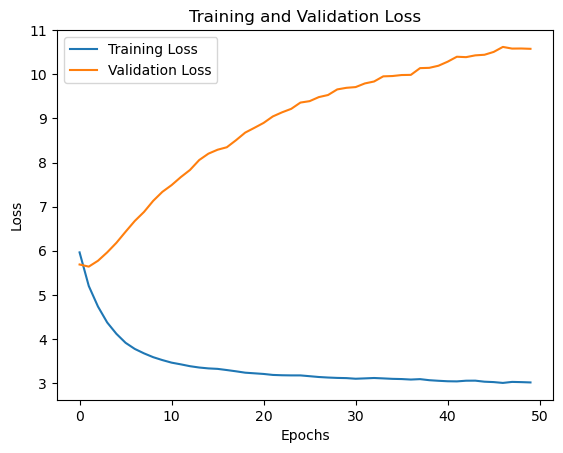

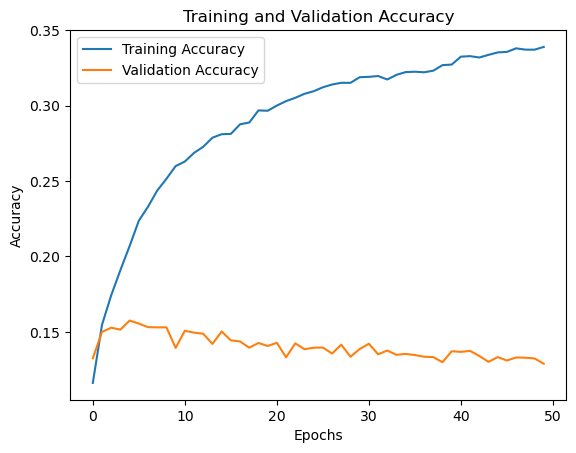

In [43]:

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Inferences

In [57]:
from IPython.display import display, HTML
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_top_five_words(model, tokenizer, seed_text, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words

def predict_and_display_top_five_words(seed_text, model, tokenizer, max_sequence_len):
    top_five_words = predict_top_five_words(model, tokenizer, seed_text, max_sequence_len)
    heading_app = f"<h1>Sentence AutoCompletion App With Five Outputs</h1>"
    output_text = f"<ul>{''.join([f'<li>{seed_text} {word}</li>' for word in top_five_words])}</ul>"
    html_content = f"<html><head><title>Top Five Words</title></head><body>{heading_app} <br> <hr> {output_text}</body></html>"
    display(HTML(html_content))


In [58]:
# Test the function
seed_text = "She is my"
predict_and_display_top_five_words(seed_text, loaded_model, tokenizer , max_sequence_len)

In [60]:
# Test 2:
# Test the function
seed_text = "I have"
predict_and_display_top_five_words(seed_text, loaded_model, tokenizer , max_sequence_len)

In [61]:
# Test 3:
# Test the function
seed_text = "We love"
predict_and_display_top_five_words(seed_text, loaded_model, tokenizer , max_sequence_len)

In [62]:
# Test 3:
seed_text = "How are"
predict_and_display_top_five_words(seed_text, loaded_model, tokenizer , max_sequence_len )